In [1]:
import os
import jnius_config

# Path to Java 21's jvm.dll
jvm_path = r"C:\Program Files\Java\jdk-21\bin\server\jvm.dll"

# Set environment variables
os.environ['JAVA_HOME'] = os.path.dirname(os.path.dirname(jvm_path))
os.environ['PATH'] += ';' + os.path.dirname(jvm_path)

# Tell jnius where to find jvm.dll
jnius_config.add_options(f'-Djava.library.path={os.path.dirname(jvm_path)}')

In [2]:
# Core & NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

# Reddit API
import praw

# IR & Search
import os
import json
import torch
from pyserini.search.lucene import LuceneSearcher

# Embedding Model
from transformers import AutoTokenizer, AutoModel

# Plot
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Thais\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thais\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [4]:
REDDIT_CLIENT_ID = "z4x8rJy3bAe3zHBRK5ucxA"
REDDIT_CLIENT_SECRET = "taVS7VaPhXAh0LHg3QDL1sH2tQzKmA"
REDDIT_USER_AGENT = "public_opinion_analysis"

reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent= REDDIT_USER_AGENT
)

def fetch_reddit_posts(query, subreddit='all', limit=100):
    posts = []
    for submission in reddit.subreddit(subreddit).search(query, sort='relevance', limit=limit):
        posts.append({
            'title': submission.title,
            'selftext': submission.selftext
        })
    return posts

In [5]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    return ' '.join(tokens)

In [6]:
def index_documents(docs, index_dir='reddit_index'):
    os.makedirs("tmp_corpus", exist_ok=True)
    with open("tmp_corpus/corpus.jsonl", "w", encoding="utf-8") as f:
        for i, doc in enumerate(docs):
            f.write(json.dumps({"id": str(i), "contents": doc}) + "\n")
    os.system(
        f"python -m pyserini.index.lucene "
        f"--collection JsonCollection "
        f"--input tmp_corpus "
        f"--index {index_dir} "
        f"--generator DefaultLuceneDocumentGenerator "
        f"--threads 2 "
        f"--storePositions --storeDocvectors --storeRaw"
    )

In [7]:
def bm25_retrieval(query, index_dir='reddit_index', top_n=20):
    searcher = LuceneSearcher(index_dir)
    hits = searcher.search(query, k=top_n)
    results = []
    for hit in hits:
        doc_json = searcher.doc(hit.docid).raw()
        doc_content = json.loads(doc_json)['contents']
        results.append((hit.docid, hit.score, doc_content))
    return results

In [8]:
def encode(text):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    return model_output.last_hidden_state.mean(dim=1)

In [9]:
def hybrid_reranking(query, retrieved_docs, alpha=0.8):
    query_embedding = encode(query)
    docs_embeddings = torch.stack([encode(doc) for _, _, doc in retrieved_docs])
    neural_scores = torch.nn.functional.cosine_similarity(query_embedding, docs_embeddings)[0].tolist()

    hybrid_docs = []
    for ((docid, bm25_score, doc), neural_score) in zip(retrieved_docs, neural_scores):
        hybrid_score = alpha * bm25_score + (1 - alpha) * neural_score
        hybrid_docs.append(((docid, bm25_score, doc), hybrid_score))

    return sorted(hybrid_docs, key=lambda x: x[1], reverse=True)

def filter_by_threshold(reranked_docs, threshold=0.0):
    return [item for item in reranked_docs if item[1] > threshold]

In [10]:
def evaluate_map(reranked_docs, relevant_ids, k=1000):
    """
    Compute MAP@k for a single query.
    """
    retrieved_docids = [docid for ((docid, _, _), _) in reranked_docs[:k]]
    num_hits = 0
    avg_precision = 0.0
    for i, docid in enumerate(retrieved_docids):
        if docid in relevant_ids:
            num_hits += 1
            avg_precision += num_hits / (i + 1)
    return avg_precision / num_hits if num_hits else 0.0


def precision_at_k(reranked_docs, relevant_ids, k=1000):
    """
    Compute Precision@k for a single query.
    """
    retrieved_docids = [docid for ((docid, _, _), _) in reranked_docs[:k]]
    num_relevant = sum(1 for docid in retrieved_docids if docid in relevant_ids)
    return num_relevant / k

def recall_at_k(reranked_docs, relevant_ids, k=1000):
    retrieved_docids = [docid for ((docid, _, _), _) in reranked_docs[:k]]
    hits = sum(1 for docid in retrieved_docids if docid in relevant_ids)
    return hits / len(relevant_ids) if relevant_ids else 0.0

In [11]:
def run_ir_pipeline(query, subreddit='stocks', alpha=0.5, threshold=0.0, relevant_ids=None, k_map=10, k_prec=5, k_recall=1000):
    """
    Run full retrieval pipeline: fetch posts, build index, retrieve, rerank, and optionally evaluate.
    """
    print(f"\n🔍 Running query: '{query}' in r/{subreddit}")
    
    # Step 1: Fetch and preprocess
    posts = fetch_reddit_posts(query, subreddit=subreddit, limit=100)
    corpus = [preprocess_text(post['title'] + ' ' + post.get('selftext', '')) for post in posts]

    # Step 2: Build index and retrieve
    index_documents(corpus)
    retrieved_docs = bm25_retrieval(query)

    # Step 3: Rerank
    reranked = hybrid_reranking(query, retrieved_docs, alpha=alpha)

    # Step 4: Filter
    filtered = filter_by_threshold(reranked, threshold=threshold)

    # Step 5: Display top results
    print(f"\nTop {min(10, len(filtered))} Results:")
    for i, ((docid, bm25_score, doc), score) in enumerate(filtered[:10], 1):
        print(f"{i}. DocID: {docid}")
        print(f"   🔹 BM25 Score: {bm25_score:.4f}")
        print(f"   🔹 Hybrid Score: {score:.4f}")
        print(f"   📄 Content Snippet: {doc[:150]}...\n")

    # Step 6: Evaluation
    if relevant_ids is not None:
        map_score = evaluate_map(filtered, relevant_ids, k=k_map)
        precision_score = precision_at_k(filtered, relevant_ids, k=k_prec)
        recall_score = recall_at_k(filtered, relevant_ids, k=k_recall)
        
        print("📊 Evaluation:")
        print(f"   ➤ MAP@1000: {map_score:.4f}")
        print(f"   ➤ Precision@1000: {precision_score:.4f}")
        print(f"   ➤ Recall@1000: {recall_score:.4f}")
    return filtered

In [12]:
def keyword_relevance_filter(docs, query, subreddit, min_overlap=2, ratio_threshold=0.6):
    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()
    def preprocess_tokens(text):
        tokens = word_tokenize(text.lower())
        return set(stemmer.stem(t) for t in tokens if t.isalpha() and t not in stop_words)

    query_tokens = preprocess_tokens(f"{query} {subreddit}")
    relevant_ids = set()
    for ((docid, _, content), _) in docs:
        content_tokens = preprocess_tokens(content)
        overlap = len(query_tokens & content_tokens)
        if overlap >= min_overlap and overlap / len(query_tokens) >= ratio_threshold:
            relevant_ids.add(docid)
    return relevant_ids

In [13]:
def plot_hybrid_scores(reranked_docs, filename):
    scores = [score for (_, score) in reranked_docs]

    plt.figure(figsize=(10, 6))
    plt.plot(scores, marker='o')
    plt.title(f"Hybrid Scores by Rank ({filename})")
    plt.xlabel("Rank")
    plt.ylabel("Hybrid Score")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"ir_model_hybrid_score_{filename}.jpg")
    plt.show()

    print(f"✅ Plot saved as: ir_model_hybrid_score_{filename}.jpg")

In [14]:
def save_top_results_to_txt(reranked_docs, filename):
    filepath = f"ir_model_top5_{filename}.txt"

    with open(filepath, "w", encoding="utf-8") as f:
        for i, ((docid, bm25_score, content), hybrid_score) in enumerate(reranked_docs[:5], 1):
            result = (
                f"{i}. DocID: {docid}\n"
                f"   🔹 BM25 Score: {bm25_score:.4f}\n"
                f"   🔹 Hybrid Score: {hybrid_score:.4f}\n"
                f"   📄 Content Snippet: {content[:200]}...\n\n"
            )
            print(result)
            f.write(result)

    print(f"✅ Top 5 results saved to: {filepath}")


🔍 Running query: 'trade agreements global economy election debates' in r/politics

Top 10 Results:
1. DocID: 2
   🔹 BM25 Score: 2.3454
   🔹 Hybrid Score: 1.8072
   📄 Content Snippet: ny democratic debate introduction done best break entirety recent debate citing relevant articles topics mentioned keeping unbiased section personal s...

2. DocID: 0
   🔹 BM25 Score: 2.1421
   🔹 Hybrid Score: 1.6853
   📄 Content Snippet: spread sensata story middle poor class citizens call media click tweet celebrities clear outsourcing problem fact romney running president usa outsour...

3. DocID: 86
   🔹 BM25 Score: 1.9711
   🔹 Hybrid Score: 1.5827
   📄 Content Snippet: trump cancels agreement sweeping trade deal asia recasting role global economy...

4. DocID: 88
   🔹 BM25 Score: 1.7871
   🔹 Hybrid Score: 1.4723
   📄 Content Snippet: trump election could threaten global climate agreement...

5. DocID: 37
   🔹 BM25 Score: 1.6986
   🔹 Hybrid Score: 1.4192
   📄 Content Snippet: discussion thread tariff 

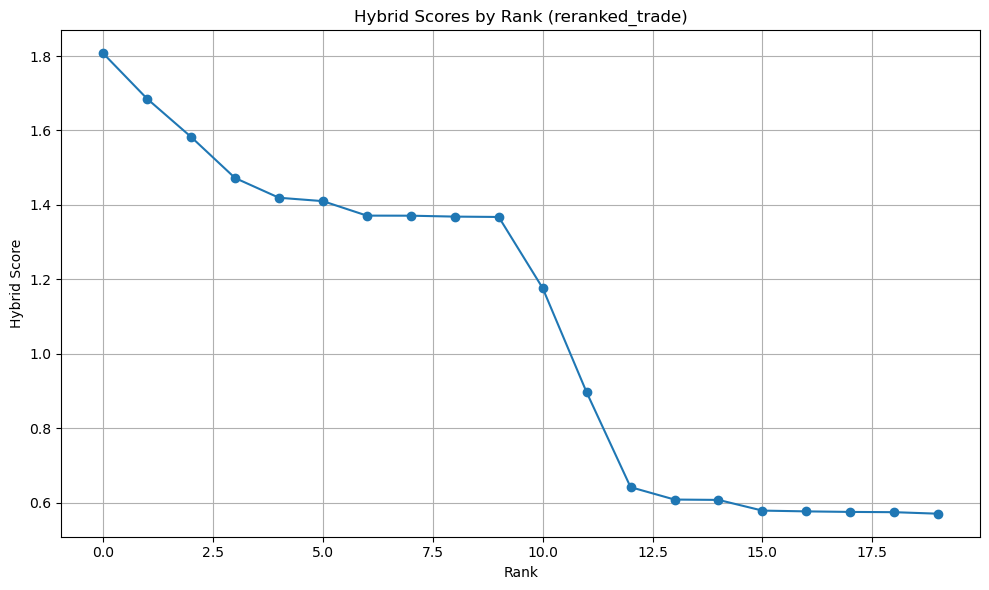

✅ Plot saved as: ir_model_hybrid_score_reranked_trade.jpg
1. DocID: 2
   🔹 BM25 Score: 2.3454
   🔹 Hybrid Score: 1.8072
   📄 Content Snippet: ny democratic debate introduction done best break entirety recent debate citing relevant articles topics mentioned keeping unbiased section personal score followed think overall ability swing undecide...


2. DocID: 0
   🔹 BM25 Score: 2.1421
   🔹 Hybrid Score: 1.6853
   📄 Content Snippet: spread sensata story middle poor class citizens call media click tweet celebrities clear outsourcing problem fact romney running president usa outsourcing record yet promising create us jobs naysayers...


3. DocID: 86
   🔹 BM25 Score: 1.9711
   🔹 Hybrid Score: 1.5827
   📄 Content Snippet: trump cancels agreement sweeping trade deal asia recasting role global economy...


4. DocID: 88
   🔹 BM25 Score: 1.7871
   🔹 Hybrid Score: 1.4723
   📄 Content Snippet: trump election could threaten global climate agreement...


5. DocID: 37
   🔹 BM25 Score: 1.6986
   🔹 Hybrid

In [15]:
# 🔍 Define query and subreddit
query = "trade agreements global economy election debates"
subreddit = "politics"

initial_docs = run_ir_pipeline(query, subreddit=subreddit, alpha=0.6, threshold=0.2)
relevant_ids = keyword_relevance_filter(initial_docs, query, subreddit, min_overlap=1, ratio_threshold=0.3)

reranked_trade = run_ir_pipeline(
    query,
    subreddit=subreddit,
    alpha=0.6,
    threshold=0.2,
    relevant_ids=relevant_ids,
)

plot_hybrid_scores(reranked_trade, "reranked_trade")
save_top_results_to_txt(reranked_trade, "reranked_trade")



🔍 Running query: 'interest rates inflation federal reserve politics' in r/politics

Top 10 Results:
1. DocID: 10
   🔹 BM25 Score: 4.3959
   🔹 Hybrid Score: 3.0375
   📄 Content Snippet: plea sanity midst alright want explain first federal reserve bank private bank exists outside scope us government means congress president authority k...

2. DocID: 18
   🔹 BM25 Score: 4.1131
   🔹 Hybrid Score: 2.8679
   📄 Content Snippet: sure see protests wall street us complaining order understand australia relevance matter first important understand reserve banks operate relationship...

3. DocID: 14
   🔹 BM25 Score: 3.7410
   🔹 Hybrid Score: 2.6446
   📄 Content Snippet: insanity government policies parties corporate controlled media silence upon read http whole range subjects issues corporate controlled media complete...

4. DocID: 64
   🔹 BM25 Score: 3.0178
   🔹 Hybrid Score: 2.2107
   📄 Content Snippet: powell federal reserve track cut rates year inflation slowing economy healthy...

5. DocID: 6


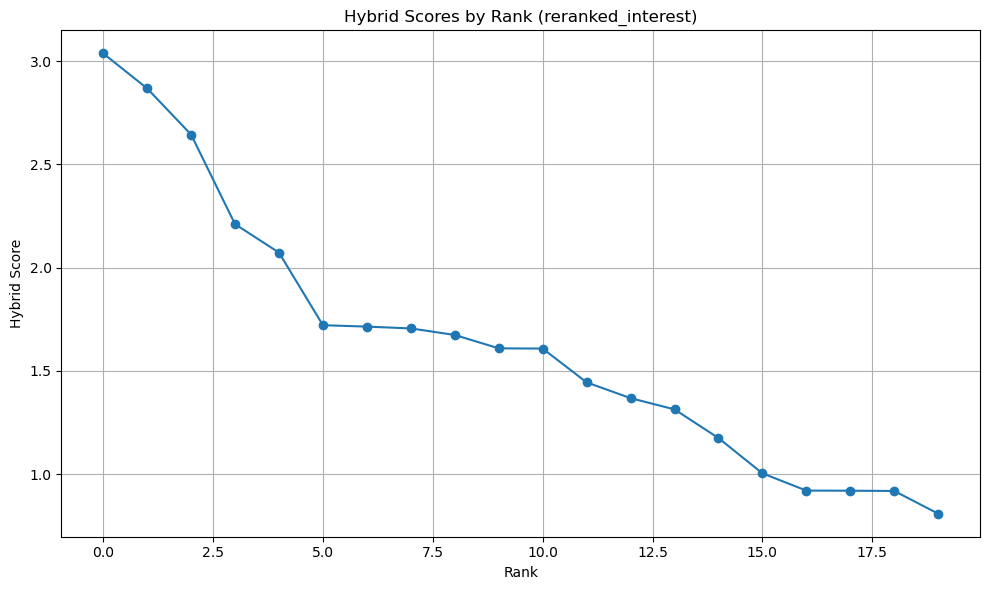

✅ Plot saved as: ir_model_hybrid_score_reranked_interest.jpg
1. DocID: 10
   🔹 BM25 Score: 4.3959
   🔹 Hybrid Score: 3.0375
   📄 Content Snippet: plea sanity midst alright want explain first federal reserve bank private bank exists outside scope us government means congress president authority know anything trillions trillions dollars loans int...


2. DocID: 18
   🔹 BM25 Score: 4.1131
   🔹 Hybrid Score: 2.8679
   📄 Content Snippet: sure see protests wall street us complaining order understand australia relevance matter first important understand reserve banks operate relationships financial sectors governments government needs m...


3. DocID: 14
   🔹 BM25 Score: 3.7410
   🔹 Hybrid Score: 2.6446
   📄 Content Snippet: insanity government policies parties corporate controlled media silence upon read http whole range subjects issues corporate controlled media completely silent never mentions real problems affecting a...


4. DocID: 64
   🔹 BM25 Score: 3.0178
   🔹 Hybrid Score: 2.2107
   

In [16]:
# 🔍 Define query and subreddit
query = "interest rates inflation federal reserve politics"
subreddit = "stocks"

# Step 1: Run once to get reranked docs (no evaluation)
initial_docs = run_ir_pipeline(query, subreddit=subreddit, alpha=0.6, threshold=0.2)

# Step 2: Generate relevant IDs from reranked docs
relevant_ids = keyword_relevance_filter(initial_docs, query, subreddit, min_overlap=1, ratio_threshold=0.3)

# Step 3: Run pipeline again, now with all three metrics at 1000
reranked_interest = run_ir_pipeline(
    query,
    subreddit=subreddit,
    alpha=0.6,
    threshold=0.2,
    relevant_ids=relevant_ids,
)

# 📈 Visualize + Save
plot_hybrid_scores(reranked_interest, "reranked_interest")
save_top_results_to_txt(reranked_interest, "reranked_interest")



🔍 Running query: 'immigration reform border security political response' in r/politics

Top 10 Results:
1. DocID: 0
   🔹 BM25 Score: 4.6241
   🔹 Hybrid Score: 3.1745
   📄 Content Snippet: discussion thread presidential address immigration tonight 8pm eastern president obama giving address immigration aired networks find list networks br...

2. DocID: 1
   🔹 BM25 Score: 3.7228
   🔹 Hybrid Score: 2.6337
   📄 Content Snippet: discussion thread year review 2019 2019 heads 2020 wanted take moment reflect past year biggest stories subreddit past discussion threads amas please ...

3. DocID: 23
   🔹 BM25 Score: 2.8032
   🔹 Hybrid Score: 2.0819
   📄 Content Snippet: megathread joseph biden sworn 46th president united states joe biden became 46th president united states wednesday declaring democracy prevailed swore...

4. DocID: 47
   🔹 BM25 Score: 2.6917
   🔹 Hybrid Score: 2.0150
   📄 Content Snippet: trump sign spending deal declare national emergency southern border senator mitch mcconnell 

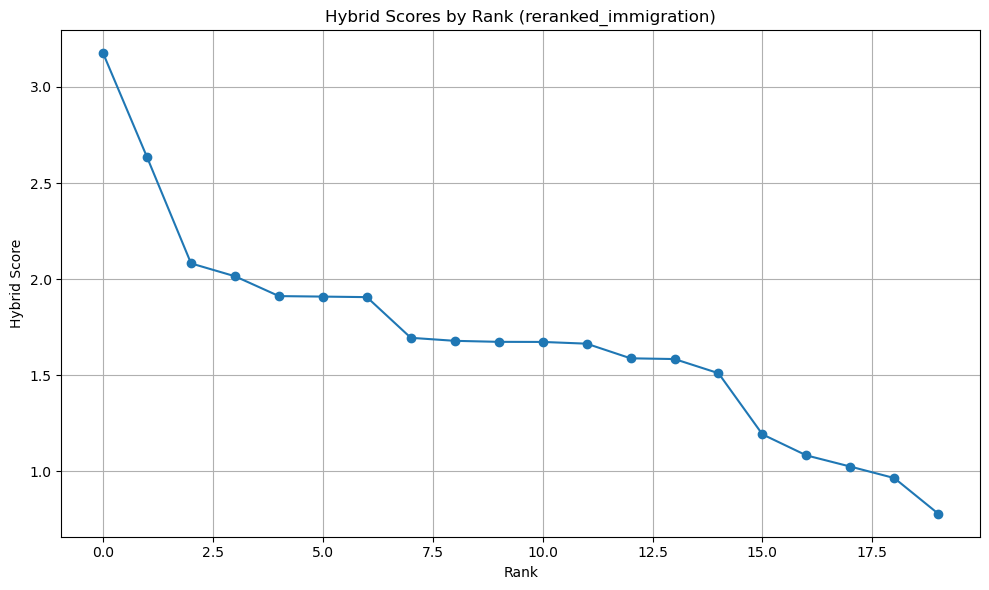

✅ Plot saved as: ir_model_hybrid_score_reranked_immigration.jpg
1. DocID: 0
   🔹 BM25 Score: 4.6241
   🔹 Hybrid Score: 3.1745
   📄 Content Snippet: discussion thread presidential address immigration tonight 8pm eastern president obama giving address immigration aired networks find list networks broadcasting address well links live streams live ad...


2. DocID: 1
   🔹 BM25 Score: 3.7228
   🔹 Hybrid Score: 2.6337
   📄 Content Snippet: discussion thread year review 2019 2019 heads 2020 wanted take moment reflect past year biggest stories subreddit past discussion threads amas please use thread discuss favorite stories moments whatev...


3. DocID: 23
   🔹 BM25 Score: 2.8032
   🔹 Hybrid Score: 2.0819
   📄 Content Snippet: megathread joseph biden sworn 46th president united states joe biden became 46th president united states wednesday declaring democracy prevailed swore oath office take helm deeply divided nation inher...


4. DocID: 47
   🔹 BM25 Score: 2.6917
   🔹 Hybrid Score: 2.0150
  

In [19]:
# ✅ Query 3: Immigration Reform

# 🔍 Define query and subreddit
query = "immigration reform border security political response"
subreddit = "politics"

# Step 1: Run once to get reranked docs (no evaluation)
initial_docs = run_ir_pipeline(query, subreddit=subreddit, alpha=0.6, threshold=0.2)

# Step 2: Generate relevant IDs from reranked docs
relevant_ids = keyword_relevance_filter(initial_docs, query, subreddit, min_overlap=1, ratio_threshold=0.3)

# Step 3: Run pipeline again
reranked_immigration = run_ir_pipeline(
    query,
    subreddit=subreddit,
    alpha=0.6,
    threshold=0.2
)

# 📈 Visualize + Save
plot_hybrid_scores(reranked_immigration, "reranked_immigration")
save_top_results_to_txt(reranked_immigration, "reranked_immigration")


🔍 Running query: 'climate change policy legislation washington' in r/politics

Top 10 Results:
1. DocID: 17
   🔹 BM25 Score: 1.9288
   🔹 Hybrid Score: 1.5573
   📄 Content Snippet: anyone know ron paul supporter actually knows views paul racist homophobic views recently covered media tip iceberg newt gingrich think ron paul views...

2. DocID: 12
   🔹 BM25 Score: 1.8904
   🔹 Hybrid Score: 1.5342
   📄 Content Snippet: ny democratic debate introduction done best break entirety recent debate citing relevant articles topics mentioned keeping unbiased section personal s...

3. DocID: 18
   🔹 BM25 Score: 1.6560
   🔹 Hybrid Score: 1.3936
   📄 Content Snippet: appeal response ndaa hello internet posting extensive facebook friends list advised appeal larger audience friend suggested could get response posting...

4. DocID: 1
   🔹 BM25 Score: 1.5093
   🔹 Hybrid Score: 1.3056
   📄 Content Snippet: discussion thread year review 2019 2019 heads 2020 wanted take moment reflect past year biggest stor

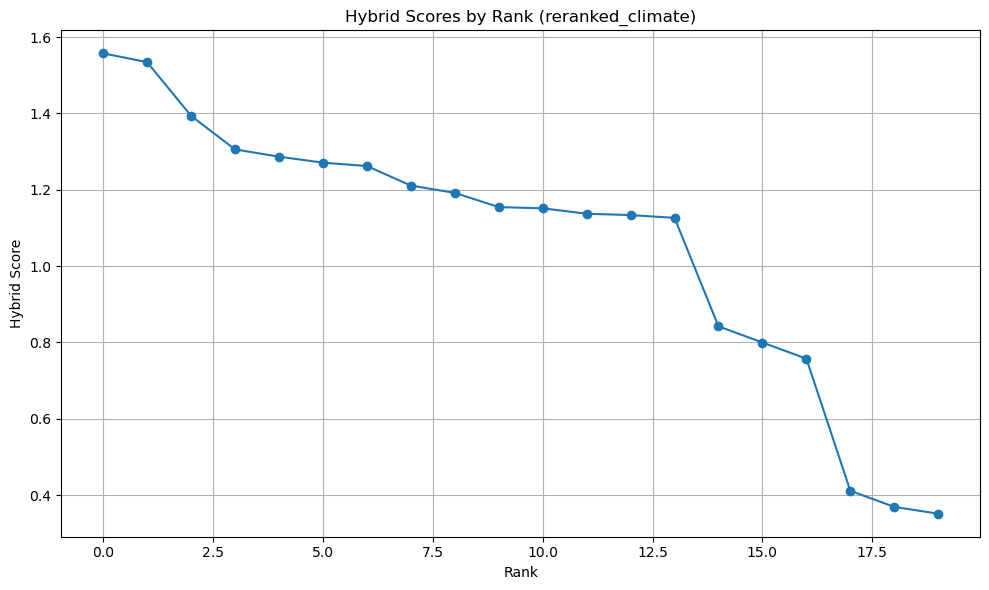

✅ Plot saved as: ir_model_hybrid_score_reranked_climate.jpg
1. DocID: 17
   🔹 BM25 Score: 1.9288
   🔹 Hybrid Score: 1.5573
   📄 Content Snippet: anyone know ron paul supporter actually knows views paul racist homophobic views recently covered media tip iceberg newt gingrich think ron paul views totally outside mainstream virtually every decent...


2. DocID: 12
   🔹 BM25 Score: 1.8904
   🔹 Hybrid Score: 1.5342
   📄 Content Snippet: ny democratic debate introduction done best break entirety recent debate citing relevant articles topics mentioned keeping unbiased section personal score followed think overall ability swing undecide...


3. DocID: 18
   🔹 BM25 Score: 1.6560
   🔹 Hybrid Score: 1.3936
   📄 Content Snippet: appeal response ndaa hello internet posting extensive facebook friends list advised appeal larger audience friend suggested could get response posting reddit enclosed facebook message hope inspire tak...


4. DocID: 1
   🔹 BM25 Score: 1.5093
   🔹 Hybrid Score: 1.3056
   📄 

In [20]:
# 🔍 Define query and subreddit
query = "climate change policy legislation washington"
subreddit = "politics"

initial_docs = run_ir_pipeline(query, subreddit=subreddit, alpha=0.6, threshold=0.2)
relevant_ids = keyword_relevance_filter(initial_docs, query, subreddit, min_overlap=1, ratio_threshold=0.3)

reranked_climate = run_ir_pipeline(
    query,
    subreddit=subreddit,
    alpha=0.6,
    threshold=0.2,
    relevant_ids=relevant_ids,
)

plot_hybrid_scores(reranked_climate, "reranked_climate")
save_top_results_to_txt(reranked_climate, "reranked_climate")



🔍 Running query: 'healthcare policy insurance premiums government politics' in r/politics

Top 10 Results:
1. DocID: 3
   🔹 BM25 Score: 6.8069
   🔹 Hybrid Score: 4.4841
   📄 Content Snippet: people criticize obama almost never anything specific say besides generalities completely unfounded statements wild made guesses intentions specific p...

2. DocID: 2
   🔹 BM25 Score: 5.9337
   🔹 Hybrid Score: 3.9602
   📄 Content Snippet: open letter bernie sanders open letter bernie sanders senator sanders year interesting fully understand grow think history needed years surrounding 17...

3. DocID: 8
   🔹 BM25 Score: 6.9587
   🔹 Hybrid Score: 3.7752
   📄 Content Snippet: facebook post one friend friends like obama speech neither thoughts like obama speech neither today health care reform actually big fan think people d...

4. DocID: 7
   🔹 BM25 Score: 6.8721
   🔹 Hybrid Score: 3.7233
   📄 Content Snippet: spreads misinformation helping insurance companies received email today states dear moveon 

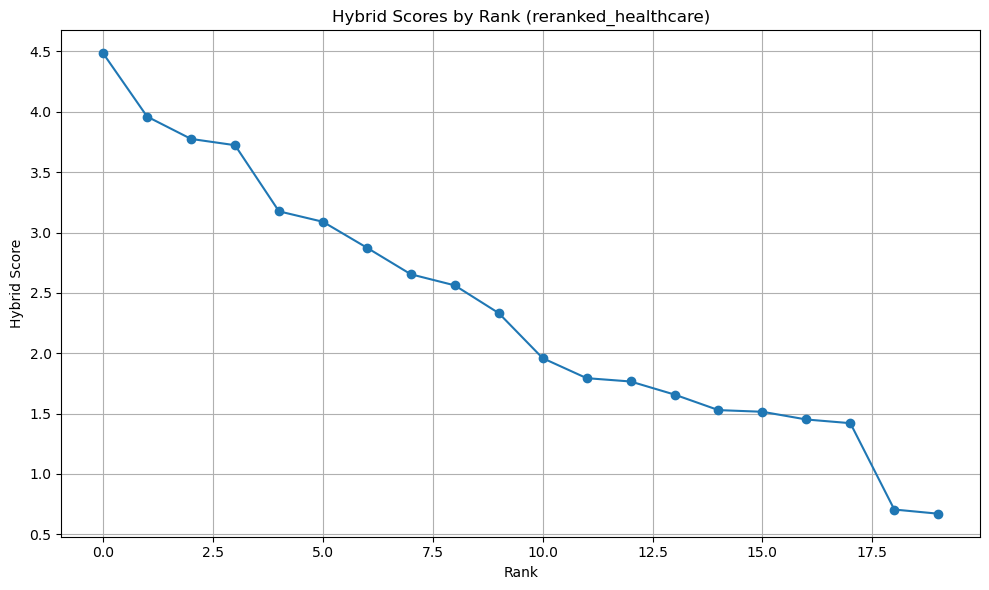

✅ Plot saved as: ir_model_hybrid_score_reranked_healthcare.jpg
1. DocID: 3
   🔹 BM25 Score: 6.8069
   🔹 Hybrid Score: 4.4841
   📄 Content Snippet: people criticize obama almost never anything specific say besides generalities completely unfounded statements wild made guesses intentions specific point usually completely blatant falsehood increasi...


2. DocID: 2
   🔹 BM25 Score: 5.9337
   🔹 Hybrid Score: 3.9602
   📄 Content Snippet: open letter bernie sanders open letter bernie sanders senator sanders year interesting fully understand grow think history needed years surrounding 1776 country deeply disgruntled many overbearing bri...


3. DocID: 8
   🔹 BM25 Score: 6.9587
   🔹 Hybrid Score: 3.7752
   📄 Content Snippet: facebook post one friend friends like obama speech neither thoughts like obama speech neither today health care reform actually big fan think people die think reduce expenditures elderly american peop...


4. DocID: 7
   🔹 BM25 Score: 6.8721
   🔹 Hybrid Score: 3.7233
   📄 

In [21]:
# 🔍 Define query and subreddit
query = "healthcare policy insurance premiums government politics"
subreddit = "politics"

initial_docs = run_ir_pipeline(query, subreddit=subreddit, alpha=0.6, threshold=0.2)
relevant_ids = keyword_relevance_filter(initial_docs, query, subreddit, min_overlap=1, ratio_threshold=0.3)

reranked_healthcare = run_ir_pipeline(
    query,
    subreddit=subreddit,
    alpha=0.6,
    threshold=0.2,
    relevant_ids=relevant_ids,
)

plot_hybrid_scores(reranked_healthcare, "reranked_healthcare")
save_top_results_to_txt(reranked_healthcare, "reranked_healthcare")
